# Regression



In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneOut, GridSearchCV
import scipy.io
import os
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier


In [10]:
path_code = os.getcwd()
bbp_dataset = scipy.io.loadmat(os.path.join(path_code, "../Data/bbp_regr.mat"))

In [11]:
ae_m = bbp_dataset["ae"].T
conf_m = bbp_dataset["conf"].T
wer_m = bbp_dataset["wer"].T
y_m = bbp_dataset["slp"].T


In [12]:
def compute_max_ind(par):
    max = 0
    for i in range(par.size):
        if max < par[i][0][0].size:
            max = par[i][0][0].size
    return max

In [13]:
c = compute_max_ind(ae_m)
ae = np.zeros([ae_m.size, c])
for i in range(ae_m.size):
    for j in range(c):
        if j < ae_m[i][0][0].size:
            ae[i,j] = ae_m[i][0][0][j]

c = compute_max_ind(conf_m)
conf = np.zeros([conf_m.size, c])
for i in range(conf_m.size):
    for j in range(c):
        if j < conf_m[i][0][0].size:
            conf[i,j] = conf_m[i][0][0][j]

c = compute_max_ind(wer_m)
wer = np.zeros([wer_m.size, c])
for i in range(wer_m.size):
    for j in range(c):
        if j < wer_m[i][0][0].size:
            wer[i,j] = wer_m[i][0][0][j]

c = compute_max_ind(y_m)
y = np.zeros([y_m.size, c])
for i in range(y_m.size):
    for j in range(c):
        if j < y_m[i][0][0].size:
            y[i,j] = y_m[i][0][0][j]

y = y.ravel()

X = np.stack((ae, conf, wer), axis=-1)

X = X.reshape(17, -1)


# Linear regressor

Nested LOOCV RMSE: 1.38


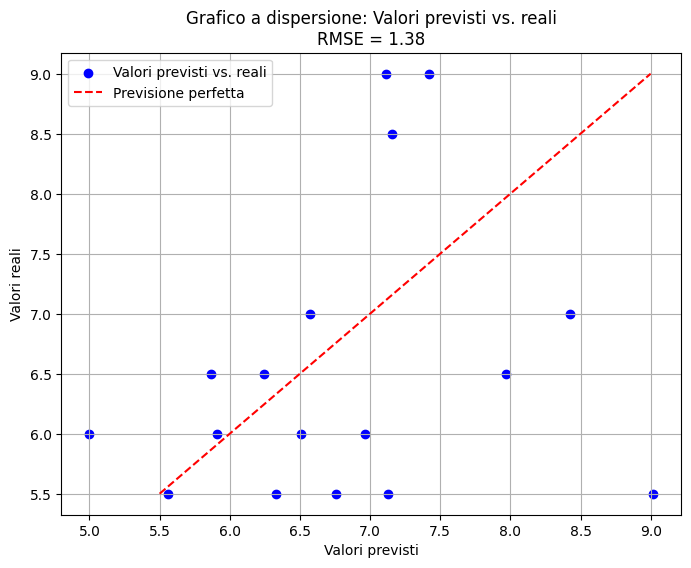

In [6]:
loo=LeaveOneOut()
y_true = []
y_pred = []
model = SVR(kernel='linear')
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1]
}
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='linear')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Valori previsti vs. reali')

# Aggiungi la linea di riferimento per una previsione perfetta
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Previsione perfetta')

# Aggiungi etichette agli assi e un titolo al grafico
plt.xlabel('Valori previsti')
plt.ylabel('Valori reali')
plt.title('Grafico a dispersione: Valori previsti vs. reali\nRMSE = {:.2f}'.format(final_rmse))

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()

# Sigmoidal regressor

In [10]:
loo=LeaveOneOut()
y_true = []
y_pred = []

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'epsilon': [0.1, 0.2, 0.5],
    'coef0': [0.0, 0.1, 0.5]
}

In [11]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='sigmoid')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

Nested LOOCV RMSE: 1.23


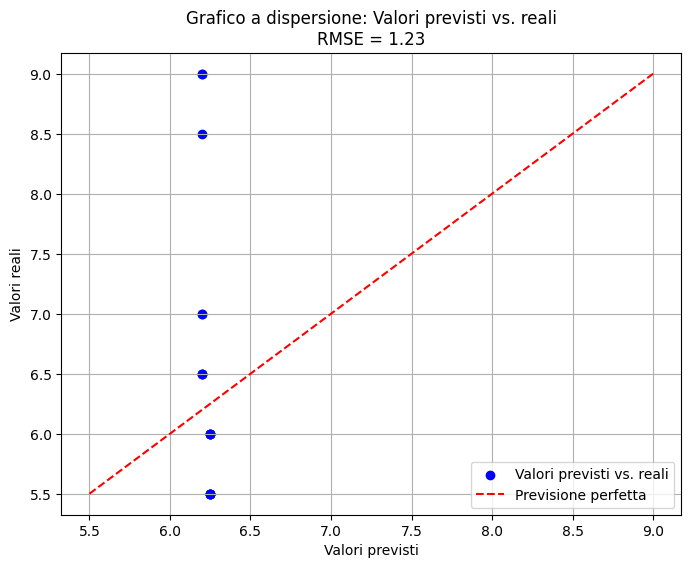

In [12]:
# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')
plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Valori previsti vs. reali')

# Aggiungi la linea di riferimento per una previsione perfetta
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Previsione perfetta')

# Aggiungi etichette agli assi e un titolo al grafico
plt.xlabel('Valori previsti')
plt.ylabel('Valori reali')
plt.title('Grafico a dispersione: Valori previsti vs. reali\nRMSE = {:.2f}'.format(final_rmse))

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()

# Neural Network

In [5]:
def create_model(neurons=32, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X.shape[1], activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1))  # Output layer per la regressione
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


In [7]:
loo = LeaveOneOut()
y_true = []
y_pred = []
param_grid = {
    'neurons': [16, 32, 64],
    'batch_size': [10, 20],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop']
}

In [14]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello Keras
    model = KerasClassifier(build_fn=create_model, verbose=0)

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_model.fit(X_train, y_train)
    y_pred.append(np.clip(best_model.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])

ValueError: Invalid parameter neurons for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(neurons=16)`
Check the list of available parameters with `estimator.get_params().keys()`